#Import Packages

In [ ]:
!pip uninstall torch
!pip install torch==1.2.0

In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error  
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

#System

In [ ]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

def cubic_2D(x, t):
    return [
            -0.1 * x[0] ** 3 + 2 * x[1] ** 3,
            -2 * x[0] ** 3 - 0.1 * x[1] ** 3,
           ]

def quadratic(t, x):
 return [-0.1 * x[0] + 2 * x[1] + 0.5* x[0]**2,
         -2 * x[0] - 0.1 * x[1]
         ]


def linear_2D(t, x):
 return [-0.1 * x[0] + 2 * x[1],
         -2 * x[0] - 0.1 * x[1]
         ]

#Data

[Text(0, 0.5, '$\\{x_1, x_2\\}$'), Text(0.5, 0, 'time')]

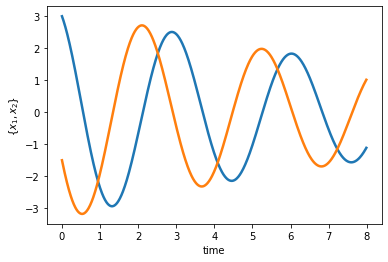

In [ ]:
dynModel = linear_2D

ts = np.arange(0,8,1e-2)
# Initial condition and simulation time
x0 = [3,-1.5]
# Solve the equation
if dynModel == linear_2D:
  sol = solve_ivp(dynModel, [ts[0], ts[-1]], x0, t_eval=ts)
elif dynModel == cubic_2D:
  sol = solve_ivp(lambda t, x: dynModel(x, t),[ts[0], ts[-1]], x0, t_eval=ts)
elif dynModel == quadratic:
  sol = solve_ivp(dynModel, [ts[0], ts[-1]], x0, t_eval=ts)

# x = sol
x = np.transpose(sol.y)
ts = sol.t
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(ts,x, linewidth = 2.5,label="Clean data")
ax.set(xlabel = 'time', ylabel = '$\{x_1, x_2\}$')

In [ ]:
#Numerical derivate calculation to compare

def derivative(input, output):

  o1 = np.hstack((0,output))
  o2 = np.hstack((output, 0))
  d_output = o1-o2

  in1 = np.hstack((0,input))
  in2 = np.hstack((input, 0))
  d_input = in1-in2

  derivative = d_output/d_input
  derivative = np.delete(derivative, 0)

  return derivative

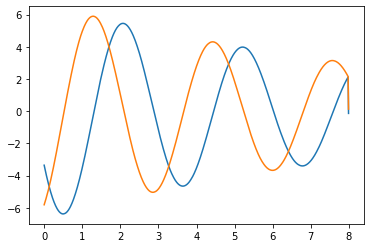

In [ ]:
dx_dt1 = derivative(ts, x[:,0])
dx_dt2 = derivative(ts, x[:,1])
dx_dt = np.column_stack((dx_dt1, dx_dt2))

plt.plot(ts, dx_dt)

In [ ]:
print(dx_dt)

[[-3.35659122 -5.8137115 ]
 [-3.46871643 -5.73967997]
 [-3.57922627 -5.66349438]
 ...
 [ 2.08073631  2.18975861]
 [ 2.12168493  2.14564412]
 [-0.13922747  0.12707018]]


In [ ]:
#Preprocessing
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
ts = ts.reshape(-1, 1)
ts = min_max_scaler.fit_transform(ts)

In [ ]:
#Tensor from Numpy
ts = torch.from_numpy(ts)
ts = torch.reshape(ts, (ts.size()[0], 1))
x = torch.from_numpy(x)

In [ ]:
#Dataloader
from torch.utils.data import TensorDataset
DataSet = TensorDataset(ts.float(), x.float())# dx_dt.float())
dataloader = DataLoader(DataSet, batch_size=800, shuffle=False)

#Dictionary

In [ ]:
class hhhh(nn.Module):
  def __init__(self,input_feature = 6, out_feat = 2):
    super().__init__()
    self.fc = nn.Linear(input_feature ,out_feat )
    self.fc.weight.data.fill_(0.0)
    self.fc.bias.data.fill_(0.0)

  def forward(self , x):
    x = self.fc(x)

    return x

In [ ]:
print(x[0])

tensor([ 3.0000, -1.5000], dtype=torch.float64)


In [ ]:
from itertools import chain
from itertools import combinations
from itertools import combinations_with_replacement as combinations_w_r

aa= chain([()],chain.from_iterable(combinations_w_r([j], i)
                        for i in range(1, 3 + 1)
                        for j in range(2)))

kk = torch.combinations(x[0], 2)
print(kk)

tensor([[ 3.0000, -1.5000]], dtype=torch.float64)


In [ ]:
def Dict_2(x):
  one = torch.ones_like(x[:,1]).view(x.shape[0], -1)

  deg_2 = torch.einsum("b f , b k -> bfk", x ,x).view(x.shape[0],-1)
  # se = torch.einsum("b f , b f k -> bfk", x, deg_2)#.view(x.shape[0],-1)
  raw =torch.cat((x,deg_2),1)
  lib = torch.cat((one, raw), 1)
  return lib

In [ ]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils.validation import check_is_fitted

class Dictionary(PolynomialFeatures):
  def __init__(self, degree=2, interaction=False, bias=True):
    super(Dictionary, self).__init__()
    self.degree = degree
    self.interaction = interaction
    self.bias = bias

  def constructing_library(self, value):
    degree = self.degree
    interaction = self.interaction
    bias = self.bias
    poly = PolynomialFeatures(degree=degree, interaction_only=interaction, include_bias=bias)
    library = poly.fit_transform(value)
    for_feature_names = PolynomialFeatures(degree=degree).fit(value)
    return library, for_feature_names.get_feature_names_out(['x0', 'x1'])

In [ ]:
def poly_dict(degree, x):
  num = 0
  for i in range(degree+2):
      num += i
  deg = torch.ones(len(x[:,0]), num).view(x.shape[0], -1)
  
  x1 = x[:,0]
  x2 = x[:,1]
  count = 0
  for i in range(degree+1): #0-1-2
    for j in range(degree+1): #0-1-2
      if i>=j:
          deg[:, count] = x1**(i-j) * x2**(j) #j=0 i=1
          count +=1
  return deg
print(poly_dict(3, x))

tensor([[  1.0000,   3.0000,  -1.5000,  ..., -13.5000,   6.7500,  -3.3750],
        [  1.0000,   2.9664,  -1.5581,  ..., -13.7112,   7.2019,  -3.7828],
        [  1.0000,   2.9317,  -1.6155,  ..., -13.8857,   7.6517,  -4.2165],
        ...,
        [  1.0000,  -1.1545,   0.9719,  ...,   1.2954,  -1.0906,   0.9182],
        [  1.0000,  -1.1336,   0.9938,  ...,   1.2772,  -1.1197,   0.9816],
        [  1.0000,  -1.1124,   1.0153,  ...,   1.2564,  -1.1467,   1.0466]])


In [ ]:
# degree = 3
# num = 0

# for i in range(degree+2):
#   num += i

# deg = torch.ones(len(x[:,1]), num).view(x.shape[0], -1)

# one = torch.ones_like(x[:,1])#.view(x.shape[0], -1)
# x1 = x[:,0]
# x2 = x[:,1]
# count = 0
# # deg[0] = torch.cat((one, x),1)
# print("degree:",degree,"\n", "num:", num)

# for i in range(degree+1): #0-1-2
#   for j in range(degree+1): #0-1-2
#     if i>=j:
#       print(count)
#       deg[:, count] = x1**(i-j) * x2**(j) #j=0 i=1
#       count +=1
        


#     # if degree>=2:
#     #     print(i)
#     #     deg[:, i+3] = deg[:,1]**(2-i) * deg[:,2]**(i)
#     #     print(deg[0,:])
#     # # if degree>=3:
#     # #     print(i)
#     # #     deg[:, i+3] = deg[:,1]**(3-i) * deg[:,2]**(i)
#     # #     print(deg[0,:])
  
# print(deg[0,:])

#   # deg[i] = torch.mul(deg[i-1], x)
# deg_2 = torch.mul(x, x)
# deg_3 = torch.mul(deg_2, x)
# print(deg)
# x1_x2 = torch.mul(x1, x2)
# x12_x2 = torch.mul(x1_x2, x1)
# x1_x22 = torch.mul(x1_x2, x2)


# if degree>=2:
#   print(degree)
#   x1x2 = torch.mul(x1, x2).view(x.shape[0], -1)
#   x1x1 = torch.mul(x1, x1).view(x.shape[0], -1)
#   x2x2 = torch.mul(x2, x2).view(x.shape[0], -1)
#   degree_2 = torch.cat((degree_1, x1x1, x1x2, x2x2),1)
# if degree>=3:

# print(x1[1],"\n", x2[1],"\n", x1x1[0],"\n", x1x2[0],"\n", x2x2[0],"\n", degree_1[0], "\n", degree_2[0], "\n", deg_3[0])


degree: 3 
 num: 10
0
1
2
3
4
5
6
7
8
9
tensor([  1.0000,   3.0000,  -1.5000,   9.0000,  -4.5000,   2.2500,  27.0000,
        -13.5000,   6.7500,  -3.3750])


In [ ]:
# def Dict_Lib(degree, x):
#   x1 = x[:,0]
#   x2 = x[:,1]
#   if degree==2:
#     degree_2 =

#     one = torch.ones_like(x[:,1])

#       deg_2 = torch.einsum("b f , b k -> bfk", x ,x).view(x.shape[0],-1)
#       # se = torch.einsum("b f , b f k -> bfk", x, deg_2)#.view(x.shape[0],-1)
#       raw =torch.cat((x,deg_2),1)
#       lib = torch.cat((one, raw), 1)


#     return library

In [ ]:
def Alpha_Dict(alpha, library):
  return torch.matmul(library.float(), alpha.float())


In [ ]:
def Sparsity(coefficient, thereshold):
  #  print(coefficient.abs())
  #  print("Zero", coefficient)
  #  Ws = coefficient.detach().clone()
  #  print("Ws.abs", Ws.abs(), thereshold)
  #  coefficient = Ws(Ws.abs() > thereshold).type(torch.float)
  #  print("second", coefficient)
  #  print("third", coefficient.requires_grad_(True))

    coefficient.requires_grad_(False)
    for i in range(coefficient.size(dim=0)):
      for j in range(coefficient.size(dim=1)):
        if torch.norm(coefficient[i, j]) < thereshold:
          coefficient[i, j] = 0
    return coefficient.requires_grad_(True)

In [ ]:
from torch._C import dtype
class network(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, activation, First_layer=False, omega_0=30):

        super(network, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        self.hidden_dim = hidden_dim
        self.First_layer = First_layer
        self.omega_0 = omega_0
        self.linear = nn.Linear(self.input_dim, self.output_dim)

        current_dim = input_dim
        self.layers = nn.ModuleList()
        for h in self.hidden_dim:
          if self.activation == "sine":
            with torch.no_grad():
              if self.input_dim==current_dim:
                self.linear.weight.uniform_(-1 / self.input_dim, 1 / self.input_dim)     
              if self.output_dim==current_dim:
                 self.linear.weight.uniform_(-np.sqrt(6 / self.output_dim) / self.omega_0, 
                                              np.sqrt(6 / self.output_dim) / self.omega_0)
              else:
                self.linear.weight.uniform_(-np.sqrt(6 / h) / self.omega_0, 
                                              np.sqrt(6 / h) / self.omega_0)

          self.layers.append(nn.Linear(current_dim, h))
          current_dim = h
        self.layers.append(nn.Linear(current_dim, output_dim))

    def forward(self, input):
      for layer in self.layers[:-1]:
        if self.activation == "sine":
          input = torch.sin(self.omega_0 * layer(input))
        else:
          input = self.activation(layer(input))

        predict_out = self.layers[-1](input)

        return predict_out

def train_net(network, alpha, optimizer1, optimizer2, library, thereshold, training_dataloader, EPOCHS = 1000):
    # alpha = torch.torch.rand(len(library[0]),2)
    # alpha.weight.requires_grad_()
    print(alpha.parameters)
    train_loss_epoch_1 = []
    train_loss_epoch_2 = []
    running_loss_1 = 0
    running_loss_2 = 0
    loss_function = nn.MSELoss()
    num = 0
    for epoch in range(EPOCHS):
      running_loss = 0
      for batch_idx, data in enumerate(training_dataloader):
          loss_1 = 0
          ts, x = data
          ts.requires_grad_()
          # x.requires_grad_()
          # optimizer1.zero_grad()
          predict_out = network(ts) 

          loss_1 = loss_function(predict_out, x)
          loss_1.backward(retain_graph=True)
          # optimizer.step()

          predict_out.requires_grad_()

          #********************************************************************
          dx1_dt = torch.autograd.grad(predict_out[:, 0], ts, grad_outputs=torch.ones_like(predict_out[:, 0]), create_graph=True)
          dx2_dt = torch.autograd.grad(predict_out[:, 1], ts, grad_outputs=torch.ones_like(predict_out[:, 1]), create_graph=True)

          dx1_dt = torch.stack(list(dx1_dt), dim=1)
          dx2_dt = torch.stack(list(dx2_dt), dim=0)

          dx1_dt = torch.reshape(dx1_dt, (800, -1))
          dx2_dt = torch.reshape(dx2_dt, (800, -1))
          dx_dt = torch.stack((dx1_dt, dx2_dt), dim=1)
          dx_dt = torch.reshape(dx_dt, (800, -1))
          #*******************************************************************
          # print(alpha.weight.size(), library.size())
          predict_dict = Alpha_Dict(alpha.weight, library)
          loss_2 = loss_function(dx_dt, predict_dict)
          loss_2.backward()
          ## with torch.no_grad():
          ##     alpha -= 1e-2 * alpha.weight.grad
              # if epoch and epoch % 1000 == 0:
              #   alpha = Sparsity(alpha, thereshold)

          optimizer1.step()
          optimizer2.step()
          
          optimizer1.zero_grad()
          optimizer2.zero_grad()

          running_loss_1 += loss_1.item()
          running_loss_2 += loss_2.item()

      train_loss_epoch_1.append(loss_1)
      train_loss_epoch_2.append(loss_2)

      num += 1
      if num %1000 == 0:
        print("epoch: ",        epoch, 
              "of batch: ",     num, 
              " Batch_Loss1: ", loss_1.item(), 
              " Batch_Loss2: ", loss_2.item()
              )
              
    return predict_out, dx_dt, train_loss_epoch_1, train_loss_epoch_2, predict_dict, alpha

def plot_results(predict_output, training_dataloader, label):
    for batch_idx, data in enumerate(training_dataloader, 0):
          ts, x= data
          break
    with torch.no_grad():      
        zl = predict_output.detach()
        plt.plot(ts.float(), zl.numpy())
        plt.title(activation_+label)


In [ ]:
print(Dict_2(x)[0])

tensor([ 1.0000,  3.0000, -1.5000,  9.0000, -4.5000, -4.5000,  2.2500],
       dtype=torch.float64)


************************************* sine *************************************
<bound method Module.parameters of Linear(in_features=2, out_features=6, bias=True)>
epoch:  999 of batch:  1000  Batch_Loss1:  2.184032917022705  Batch_Loss2:  0.25531071424484253
epoch:  1999 of batch:  2000  Batch_Loss1:  1.8307510614395142  Batch_Loss2:  0.01629362441599369
epoch:  2999 of batch:  3000  Batch_Loss1:  1.4504669904708862  Batch_Loss2:  0.02424159087240696
epoch:  3999 of batch:  4000  Batch_Loss1:  1.1341121196746826  Batch_Loss2:  0.021137459203600883
epoch:  4999 of batch:  5000  Batch_Loss1:  0.8398494124412537  Batch_Loss2:  0.020960791036486626
epoch:  5999 of batch:  6000  Batch_Loss1:  0.5896593928337097  Batch_Loss2:  0.01819726824760437
epoch:  6999 of batch:  7000  Batch_Loss1:  0.34010928869247437  Batch_Loss2:  0.018742192536592484
epoch:  7999 of batch:  8000  Batch_Loss1:  0.17357836663722992  Batch_Loss2:  0.006284012924879789
epoch:  8999 of batch:  9000  Batch_Loss1:  0.

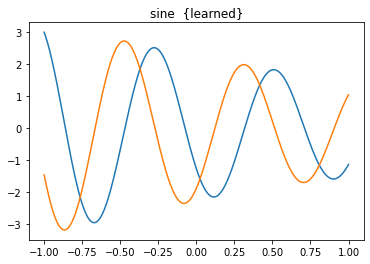

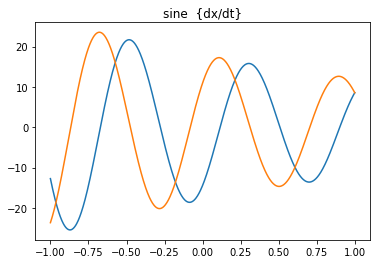

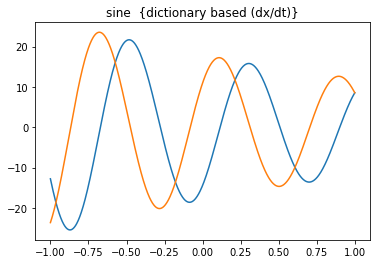

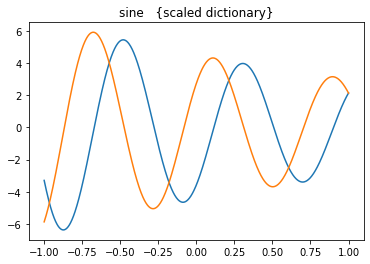

In [ ]:
epoch = 30000
Threshold = 0.09
Polynomial_degree = 2

# Dict = Dictionary(degree=Polynomial_degree, interaction=False, bias=True)
# Library, feature_names = Dict.constructing_library(x)
# Library = torch.from_numpy(Library_)
# print("library:   ", Library, '\n\n', "feature names:   ", feature_names)
Library = poly_dict(2, x)


coeff_init = nn.Linear(2, len(Library[0]))
with torch.no_grad():
  coeff_init.weight.fill_(0.0)

list_activations = ["sine"] #nn.ELU(), nn.Tanh(), nn.ReLU(), nn.SELU()

for activation_ in list_activations:
  print("*************************************", activation_, "*************************************")
  net = network(1, 2, [16, 32, 32, 16], activation_)

  Optimizer_1 = optim.Adam(net.parameters(), lr = 1e-4) 
  Optimizer_2 = optim.Adam(coeff_init.parameters(), lr = 1e-2) 

  Predict, dx_dt, loss_1, loss_2, predict_dict, coeff = train_net(network = net, 
                                                                  alpha      = coeff_init, 
                                                                  optimizer1 = Optimizer_1, 
                                                                  optimizer2 = Optimizer_2, 
                                                                  library    = Library, 
                                                                  thereshold = Threshold, 
                                                                  training_dataloader = dataloader, 
                                                                  EPOCHS     = epoch)
  # coeff = Sparsity(coeff, Threshold)
  loss_1.append(loss_1)
  loss_2.append(loss_2)

  plt.figure()
  plot_results(Predict, dataloader, "  {learned}")

  plt.figure()
  plot_results(dx_dt, dataloader, "  {dx/dt}")

  plt.figure()
  plot_results(predict_dict, dataloader, "  {dictionary based (dx/dt)}")

  scale = torch.tensor(min_max_scaler.data_range_)/2
  coefficient = coeff.weight.float()/scale.float()
  coefficient_no_grad = coefficient.detach()
  coefficient = Sparsity(coefficient_no_grad, Threshold)

  plt.figure()
  plot_results(Alpha_Dict(coefficient, Library), dataloader, "   {scaled dictionary}")

print("\n\n Sparse coefficient: \n" , coefficient)
